In [81]:
import pandas as pd
import json 
import numpy as np 
import matplotlib.pyplot as plt

In [101]:
def date_difference(date_yyyymmdd, date_yyyymm):
    month_diff = (int(date_yyyymmdd[:4]) - int(date_yyyymm[:4])) * 12
    if len(date_yyyymm) == 4:
        return month_diff
    return month_diff + (int(date_yyyymm[4:]) - int(date_yyyymmdd[4:6]))

In [406]:
def preprocess_data(json_file: dict):
    rows = []
    drug_infos = []
    for result in json_file['results']:
        rows.append(
            {'SourceCountry': result['primarysourcecountry'] if 'primarysourcecountry' in result.keys() else None,
             'Qualification': result['primarysource']['qualification'] if 'qualification' in result[
                 'primarysource'].keys() else None,
             'SetAge': result['patient']['patientonsetage'] if 'patientonsetage' in result['patient'].keys() else None,
             'Sex': result['patient']['patientsex'] if 'patientsex' in result['patient'].keys() else None,
             'Serious': result['serious']
             })
        for drug in result['patient']['drug']:
            if 'activesubstance' not in drug.keys():
                continue
            rows[-1][drug['activesubstance']['activesubstancename']] = 1
            if 'DrugChar' + str(drug['drugcharacterization']) in rows[-1].keys():
                rows[-1]['DrugChar' + str(drug['drugcharacterization'])] += 1
            else:
                rows[-1]['DrugChar' + str(drug['drugcharacterization'])] = 1
            if 'drugstructuredosagenumb' in drug.keys():
                rows[-1][drug['activesubstance']['activesubstancename'] + 'Dosage'] = drug['drugstructuredosagenumb']
            else:
                rows[-1][drug['activesubstance']['activesubstancename'] + 'Dosage'] = 'Missing'
            if 'drugstartdate' in drug.keys():
                if 'MostRecentDrug' in rows[-1].keys():
                    rows[-1]['MostRecentDrug'] = min(rows[-1]['MostRecentDrug'],
                                                     date_difference(result['receivedate'], drug['drugstartdate']))
                else:
                    rows[-1]['MostRecentDrug'] = date_difference(result['receivedate'], drug['drugstartdate'])
    return rows

In [407]:
f = open('sample_data.json')
data = json.load(f)

In [408]:
data = preprocess_data(data)
data = pd.DataFrame(data)

In [409]:
data

,SourceCountry,Qualification,SetAge,Sex,Serious,ABIRATERONE ACETATE,DrugChar1,ABIRATERONE ACETATEDosage,MostRecentDrug,DUTASTERIDE,...,TYROSINE,TYROSINEDosage,LEVOBUNOLOL,LEVOBUNOLOLDosage,ZIPRASIDONE MESYLATE,ZIPRASIDONE MESYLATEDosage,ASCORBIC ACID\CALCIUM PHOSPHATE\CHOLECALCIFEROL\CITRIC ACID MONOHYDRATE,ASCORBIC ACID\CALCIUM PHOSPHATE\CHOLECALCIFEROL\CITRIC ACID MONOHYDRATEDosage,CYANOCOBALAMIN\PYRIDOXINE\THIAMINE,CYANOCOBALAMIN\PYRIDOXINE\THIAMINEDosage
0,US,2,80,1,2,1.0,1,1000,-2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,US,3,55,2,2,NaN,1,NaN,422.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US,3,None,None,2,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US,1,53,1,1,NaN,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DE,1,77,1,1,NaN,1,NaN,952.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,US,None,24440,2,1,NaN,10,NaN,254.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11996,US,None,23882,2,1,NaN,1,NaN,194.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11997,JP,1,77,1,1,NaN,2,NaN,364.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11998,US,5,38,1,2,NaN,1,NaN,60.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [410]:
indices = ['Dosage' in d for d in data.columns]

In [411]:
dosage_cols = list(data.loc[:, indices].columns)
drug_cols = [s.replace('Dosage', '') for s in dosage_cols]

In [412]:
# replace drug columns nan with 0 (since they didn't take the drug)
data[drug_cols] = data[drug_cols].replace(np.nan, 0)

In [413]:
data[dosage_cols] = data[dosage_cols].replace(np.nan, 0)
data[dosage_cols] = data[dosage_cols].replace('Missing', 0)

In [414]:
data = data.fillna(np.nan)

In [415]:
missing_vals = data.isna().sum() / data.shape[0]

In [416]:
missing_vals = missing_vals[missing_vals > 0]

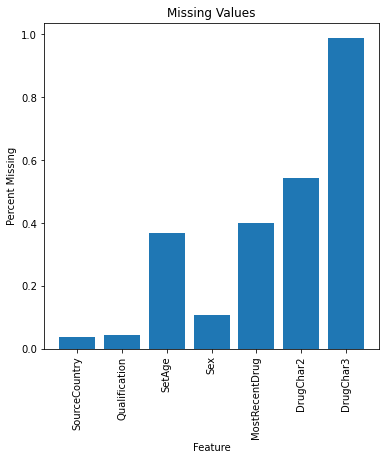

In [417]:
plt.figure(figsize = (6, 6))

plt.bar(x = missing_vals.index, height = missing_vals.values)

plt.xticks(rotation = 90)
plt.title('Missing Values')
plt.xlabel('Feature') 
plt.ylabel('Percent Missing')

plt.show()

In [418]:
label_counts = (data['Serious'].value_counts()) / sum(data['Serious'].value_counts())

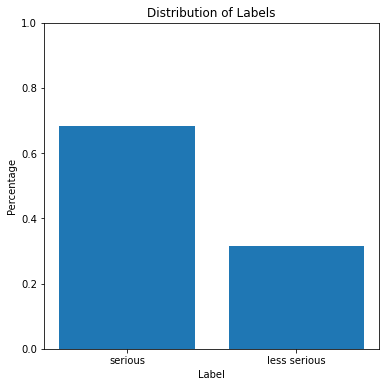

In [419]:
plt.figure(figsize = (6, 6))

plt.bar(x = label_counts.index, height = label_counts.values)

plt.xlabel('Label')
plt.ylabel('Percentage') 
plt.title('Distribution of Labels')

plt.ylim([0, 1])
plt.xticks(labels = ['serious', 'less serious'], ticks = [0, 1])

plt.show()

In [420]:
data['Sex'] = data['Sex'].replace('0', np.nan)

In [421]:
female_counts = data[data['Sex'] == '2']['Serious'].value_counts()
male_counts = data[data['Sex'] == '1']['Serious'].value_counts()

In [422]:
gender_data = pd.concat((female_counts, male_counts), axis = 1)

In [423]:
gender_data.columns = ['female', 'male']

In [424]:
gender_data = gender_data / 12000

<Figure size 432x432 with 0 Axes>

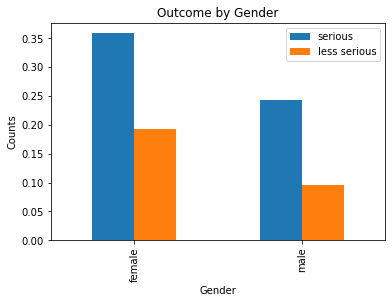

In [425]:
plt.figure(figsize = (6, 6))

gender_data.T.plot.bar()

plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('Outcome by Gender')
plt.legend(labels = ['serious', 'less serious'])

plt.show()

In [426]:
data['SetAge'] = data['SetAge'].astype(float)

In [427]:
data['SetAge'] = data['SetAge'].replace(np.nan, -10)

In [428]:
data = data.loc[data['SetAge'] < 101, :]

In [429]:
data['SetAge'] = data['SetAge'].replace(-10, np.nan)

In [430]:
data = data.drop(['DrugChar2', 'DrugChar3'], axis = 1)

# Modeling

In [431]:
y = data['Serious']
X = data.drop('Serious', axis = 1)

In [432]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2)

In [433]:
from sklearn.impute import SimpleImputer 

ss_cont = SimpleImputer(strategy = 'mean') 
ss_cat = SimpleImputer(strategy = 'most_frequent')

In [434]:
X_train[['SourceCountry', 'Sex', 'Qualification']] = ss_cat.fit_transform(X_train[['SourceCountry', 'Sex', 'Qualification']])


In [435]:
X_test[['SourceCountry', 'Sex', 'Qualification']] = ss_cat.transform(X_test[['SourceCountry', 'Sex', 'Qualification']])

In [436]:
X_train[['SetAge', 'MostRecentDrug']] = ss_cont.fit_transform(X_train[['SetAge', 'MostRecentDrug']])
X_test[['SetAge', 'MostRecentDrug']] = ss_cont.transform(X_test[['SetAge', 'MostRecentDrug']])

In [437]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [438]:
X_train = X_train.drop('SourceCountry', axis = 1)
X_test = X_test.drop('SourceCountry', axis = 1)

In [439]:
X_train

,Qualification,SetAge,Sex,ABIRATERONE ACETATE,DrugChar1,ABIRATERONE ACETATEDosage,MostRecentDrug,DUTASTERIDE,DUTASTERIDEDosage,SILODOSIN,...,TYROSINE,TYROSINEDosage,LEVOBUNOLOL,LEVOBUNOLOLDosage,ZIPRASIDONE MESYLATE,ZIPRASIDONE MESYLATEDosage,ASCORBIC ACID\CALCIUM PHOSPHATE\CHOLECALCIFEROL\CITRIC ACID MONOHYDRATE,ASCORBIC ACID\CALCIUM PHOSPHATE\CHOLECALCIFEROL\CITRIC ACID MONOHYDRATEDosage,CYANOCOBALAMIN\PYRIDOXINE\THIAMINE,CYANOCOBALAMIN\PYRIDOXINE\THIAMINEDosage
7419,1,55.954,2,0.0,1,0,351.470839,0.0,0,0.0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
1869,1,55.954,1,0.0,1,0,351.470839,0.0,0,0.0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
1776,5,55.954,2,0.0,1,0,351.470839,0.0,0,0.0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
744,1,75.000,1,0.0,6,0,-3.000000,0.0,0,0.0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
1675,5,55.954,2,0.0,1,0,351.470839,0.0,0,0.0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8388,3,55.954,2,0.0,1,0,306.000000,0.0,0,0.0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
8536,3,55.000,1,0.0,4,0,351.470839,0.0,0,0.0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
4019,5,52.000,2,0.0,4,0,132.000000,0.0,0,0.0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
5638,3,55.954,1,0.0,1,0,213.000000,0.0,0,0.0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0


In [440]:
from sklearn.linear_model import LogisticRegression

In [442]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [443]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

lr.score(X_test, y_test)

/Users/rmcnamara4/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7476754015215553

In [446]:
from sklearn.pipeline import make_pipeline

In [449]:
from sklearn.decomposition import PCA

In [456]:
from sklearn.ensemble import RandomForestClassifier

In [458]:
from xgboost import XGBClassifier
pca_lr = make_pipeline(StandardScaler(),PCA(n_components=15),XGBClassifier())
pca_lr.fit(X_train,y_train)
print('Train : ',pca_lr.score(X_train,y_train))
print('Test : ',pca_lr.score(X_test,y_test))

/Users/rmcnamara4/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train :  0.8432843707069639
Test :  0.7362637362637363


In [459]:
pca_lr = make_pipeline(StandardScaler(),PCA(n_components=15),RandomForestClassifier(n_estimators = 250, max_depth = 25))
pca_lr.fit(X_train,y_train)
print('Train : ',pca_lr.score(X_train,y_train))
print('Test : ',pca_lr.score(X_test,y_test))

Train :  0.9025678960160626
Test :  0.7544378698224852


In [460]:
import tensorflow as tf

In [474]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

nn = tf.keras.Sequential([
    Dense(64, activation = 'relu', input_shape = (X_train.shape[1], )), 
    BatchNormalization(), 
    Dense(128, activation = 'relu'), 
    BatchNormalization(), 
    Dense(128, activation = 'relu'), 
    BatchNormalization(), 
    Dense(64, activation = 'relu'), 
    BatchNormalization(), 
    BatchNormalization(), 
    Dense(1, activation = 'sigmoid')
])

In [475]:
nn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [476]:
nn.fit(X_train, y_train, epochs = 100)

Epoch 1/100
296/296 [==============================] - 3s 5ms/step - loss: 0.6540 - accuracy: 0.6621
Epoch 2/100
296/296 [==============================] - 1s 4ms/step - loss: 0.4325 - accuracy: 0.8051
Epoch 3/100
296/296 [==============================] - 1s 4ms/step - loss: 0.3657 - accuracy: 0.8376
Epoch 4/100
296/296 [==============================] - 1s 4ms/step - loss: 0.3513 - accuracy: 0.8401
Epoch 5/100
296/296 [==============================] - 1s 3ms/step - loss: 0.3064 - accuracy: 0.8625
Epoch 6/100
296/296 [==============================] - 1s 3ms/step - loss: 0.2890 - accuracy: 0.8681: 0s
Epoch 7/100
296/296 [==============================] - 1s 3ms/step - loss: 0.2846 - accuracy: 0.8679
Epoch 8/100
296/296 [==============================] - 1s 4ms/step - loss: 0.2818 - accuracy: 0.8735
Epoch 9/100
296/296 [==============================] - 1s 3ms/step - loss: 0.2652 - accuracy: 0.8760
Epoch 10/100
296/296 [==============================] - 1s 3ms/step - loss: 0.2640 - ac

296/296 [==============================] - 1s 3ms/step - loss: 0.1491 - accuracy: 0.9328
Epoch 82/100
296/296 [==============================] - 1s 3ms/step - loss: 0.1469 - accuracy: 0.9326
Epoch 83/100
296/296 [==============================] - 1s 4ms/step - loss: 0.1459 - accuracy: 0.9308
Epoch 84/100
296/296 [==============================] - 1s 4ms/step - loss: 0.1408 - accuracy: 0.9368
Epoch 85/100
296/296 [==============================] - 1s 3ms/step - loss: 0.1453 - accuracy: 0.9372
Epoch 86/100
296/296 [==============================] - 1s 3ms/step - loss: 0.1451 - accuracy: 0.9333
Epoch 87/100
296/296 [==============================] - 1s 3ms/step - loss: 0.1396 - accuracy: 0.9426
Epoch 88/100
296/296 [==============================] - 1s 3ms/step - loss: 0.1475 - accuracy: 0.9320
Epoch 89/100
296/296 [==============================] - 1s 4ms/step - loss: 0.1394 - accuracy: 0.9352
Epoch 90/100
296/296 [==============================] - 2s 7ms/step - loss: 0.1351 - accuracy: 

In [477]:
nn.evaluate(X_test, y_test)

74/74 [==============================] - 0s 2ms/step - loss: 1.0586 - accuracy: 0.7790


[1.0586217641830444, 0.7789518237113953]